In [1]:
import scipy.io
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_style("darkgrid")
import scipy
import math
import zlib
from scipy import stats
from scipy import signal
from itertools import *
sns.plt = plt
np.random.seed(1) # No estoy seguro si es necesario


In [2]:
dataset_sujetos_str = []
for i in range(1,10):
    dataset_sujetos_str.append('P0'+str(i))
    dataset_sujetos_str.append('S0'+str(i))
dataset_sujetos_str.append('P10')
dataset_sujetos_str.append('S10')


In [3]:
def electrodos_importantes(dataset):
    electrodo8 = dataset[:, 7, :]
    electrodo44 = dataset[:, 43, :]
    electrodo80 = dataset[:, 79, :]
    electrodo131 = dataset[:, 130, :]
    electrodo185 = dataset[:, 184, :]

    return [electrodo8, electrodo44, electrodo80, electrodo131, electrodo185]


In [4]:
def epoch_count(dataset):
    return dataset.shape[0]

def electrodes_count(dataset):
    return dataset.shape[2]

def averageTimeSeries(tsList):
    for i in range(len(tsList[0])):
        yield np.mean(map(lambda ts: ts[i], tsList))

def averageInEpoch(epoch_idx, dataset):
    return averageTimeSeries(map(lambda electrodo: electrodo[epoch_idx], electrodos_importantes(dataset)))


In [5]:
def freq_pots_relevantes(freqs, pots):
    pairs_relevantes = filter(lambda x: x[0] <= 45.0, zip(freqs, pots))
    freqs_relevantes = map(lambda x: x[0], pairs_relevantes)
    amplitudes_relevantes = map(lambda x: x[1], pairs_relevantes)
    return (freqs_relevantes, amplitudes_relevantes)
    

In [6]:
def graph_fft(dataset):
    epoch_count(dataset)
    averagedElectrodesByEpoch = [list(averageInEpoch(i,dataset)) for i in range(epoch_count(dataset))] 
    allEpochs = pd.DataFrame();
    for i in range(epoch_count(dataset)):
        epoch_welch = scipy.signal.welch(averagedElectrodesByEpoch[i], fs=250)
        frecuencas_sampleadas = epoch_welch[0]; # Deberia ser siempre lo mismo
        (freqs_relevantes, pots_relevantes) = freq_pots_relevantes(frecuencas_sampleadas, epoch_welch[1])
        allEpochs = allEpochs.append(pd.DataFrame(pots_relevantes).transpose());

    allEpochs = allEpochs.reset_index();
    sns.heatmap(allEpochs.transpose(), cmap="viridis", vmax=2e-11 )
    del allEpochs
    plt.show()

    

In [7]:
def get_epoch(epoch_idx,electrodo_idx, dataset):
    return dataset[epoch_idx, electrodo_idx, :]

def par_frecuencias_potencias_epoch(epoch_idx,electrodo_idx,dataset):
    welch_result = scipy.signal.welch(get_epoch(epoch_idx,electrodo_idx,dataset), fs=250)
    return freq_pots_relevantes(welch_result[0], welch_result[1])

# Dado un dataset y un electrodo devuelve una lista de potencias promedio para cada epoch
def potencias_promedio(electrodo_idx,dataset):
    potencias = [par_frecuencias_potencias_epoch(i,electrodo_idx, dataset)[1] for i in range(epoch_count(dataset))]
    res = []
    for i in range(len(potencias[0])):
        res.append(np.average([potencias[j][i] for j in range(len(potencias))]))
    del potencias
    return res

def graph_potencias(dataset):
    colors = sns.color_palette("muted", n_colors=electrodes_count(dataset))
    for i in range(electrodes_count(dataset)):
        sns.tsplot(potencias_promedio(i, dataset), color=colors[i])
    plt.show()

In [8]:
datasetPrincipal = scipy.io.loadmat('datos/S01.mat')['data']


/home/brian/Documents/facultad/cienciadatos/venv/local/lib/python2.7/site-packages/scipy/signal/spectral.py:1633: UserWarning: nperseg = 256 is greater than input length  = 201, using nperseg = 201
  .format(nperseg, input_length))


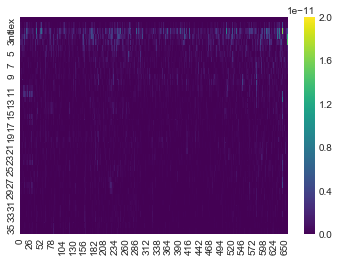

In [9]:
graph_fft(datasetPrincipal)

/home/brian/Documents/facultad/cienciadatos/venv/local/lib/python2.7/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


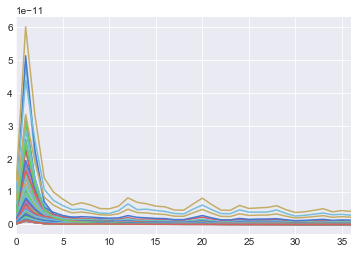

In [10]:
graph_potencias(datasetPrincipal)

In [9]:
del datasetPrincipal

In [10]:
def potencia_banda(low, high, potencias_promedio, frecuencias):
    # Thomas dice np.average
    return np.average(map(lambda x: x[0], ifilter(lambda x: x[1] >= low and x[1] < high, izip(potencias_promedio, frecuencias))))

def get_bandas_dict(dataset):
    potencias_promedio_by_electrode = []
    for i in range(electrodes_count(dataset)):
        potencias_promedio_by_electrode.append(potencias_promedio(i, dataset))
    potencias_promedio_total = [np.average([potencias_promedio_by_electrode[j][i] for j in range(len(potencias_promedio_by_electrode))]) for i in range(len(potencias_promedio_by_electrode[0]))]
    del potencias_promedio_by_electrode
    frecuencias = par_frecuencias_potencias_epoch(0,0, dataset)[0]
    res = {}
    res['delta'] = potencia_banda(0., 4.0, potencias_promedio_total, frecuencias)
    res['theta'] = potencia_banda(4.0, 8.0, potencias_promedio_total, frecuencias)
    res['alpha'] = potencia_banda(8.0, 13.0, potencias_promedio_total, frecuencias)
    res['beta'] = potencia_banda(13.0, 30., potencias_promedio_total, frecuencias)
    res['gamma'] = potencia_banda(30.0, 125., potencias_promedio_total, frecuencias)
    
    return res

In [11]:
import math
import zlib
def to_symb(l):
    maxi = np.max(l)
    mini = np.min(l)
    def scott_N():
        std = np.std(l)
        n = float(len(l))
        return int(math.ceil((maxi - mini) / (3.5 * std * (n**(-1./3.)))))
    
    N = scott_N()
    bin_size = (maxi - mini) / float(N) 
    for x in l:
        if x == maxi:
            yield N - 1
        else:
            symbol = int((x - mini) / bin_size)
            yield symbol
            
            
def to_str_symb(l):
    return ''.join(imap(str, to_symb(l)))

def kolmog_approx(l):
    compressed = zlib.compress(to_str_symb(l), 9)
    return len(compressed)

In [12]:
x = [-7.3, -6.2, 3.4, 2.1, 0.2, 9.2]
print list(to_symb(x))

print to_str_symb(x)


print kolmog_approx(x)

[0, 0, 1, 1, 0, 1]
001101
14


In [18]:
def info_intra_electrodo(dataset):
    total = 0.
    for i in range(epoch_count(dataset)):
        for j in range(electrodes_count(dataset)):
            total += kolmog_approx(get_epoch(i, j, dataset))
    promedio = float(total) / float(epoch_count(dataset) * electrodes_count(dataset))
    return promedio

In [14]:
#datasetPrincipal = scipy.io.loadmat('datos/S01.mat')['data']
#print info_intra_electrodo(datasetPrincipal)

In [16]:
bandas_frame_columns = ['delta','theta','alpha','beta','gamma','tipo', 'info_intra']
bandas_frame = pd.DataFrame(data=[], columns=bandas_frame_columns)

for sujeto_str in dataset_sujetos_str[0:4]:
    dataset = scipy.io.loadmat('datos/{0}.mat'.format(sujeto_str))['data']
    bandas_dict = get_bandas_dict(dataset)
    if sujeto_str[0] == 'P':
        bandas_dict['tipo'] = 'normal'
    else:
        bandas_dict['tipo'] = 'disminuido'
    bandas_dict['info_intra'] = info_intra_electrodo(dataset)
    bandas_sujeto = pd.DataFrame(data=[bandas_dict], columns=bandas_frame_columns)
    bandas_frame = bandas_frame.append(bandas_sujeto)

In [17]:
print bandas_frame

          delta         theta         alpha          beta         gamma  \
0  6.563069e-12  1.246806e-12  4.485051e-13  1.983459e-13  1.604475e-13   
0  2.982860e-12  8.169761e-13  6.708537e-13  3.538571e-13  2.067432e-13   
0  1.272164e-11  3.368208e-12  5.829568e-13  3.194208e-13  1.822494e-13   
0  2.388813e-12  1.485615e-12  6.040987e-12  3.185578e-13  6.348191e-14   

         tipo  info_intra  
0      normal   74.968953  
0  disminuido   94.066426  
0      normal   72.093615  
0  disminuido   83.322845  


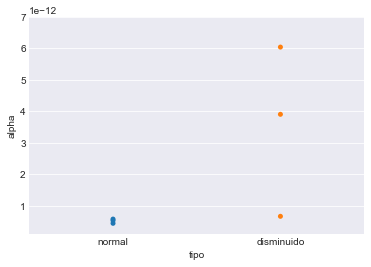

In [17]:
sns.stripplot(data=bandas_frame, y="alpha", x="tipo")
plt.ylim(1e-13, 7e-12)
plt.show()


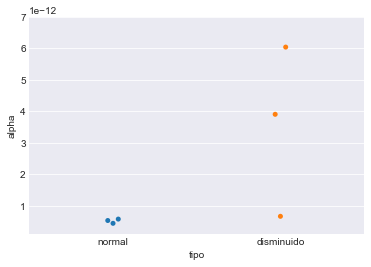

In [18]:
sns.swarmplot(x="tipo", y="alpha", data=bandas_frame)
plt.ylim(1e-13, 7e-12)
plt.show()

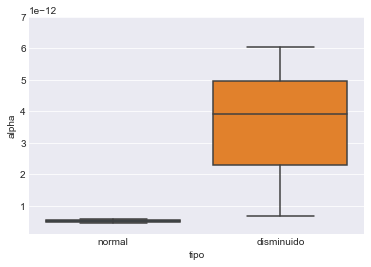

In [19]:
sns.boxplot(x="tipo", y="alpha", data=bandas_frame)
plt.ylim(1e-13, 7e-12)
plt.show()

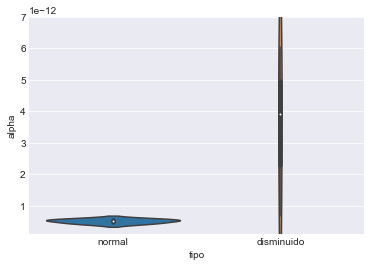

In [20]:
sns.violinplot(x="tipo", y="alpha", data=bandas_frame)
plt.ylim(1e-13, 7e-12)
plt.show()

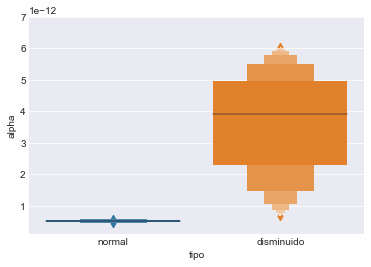

In [21]:
sns.lvplot(x="tipo", y="alpha", data=bandas_frame)
plt.ylim(1e-13, 7e-12)
plt.show()

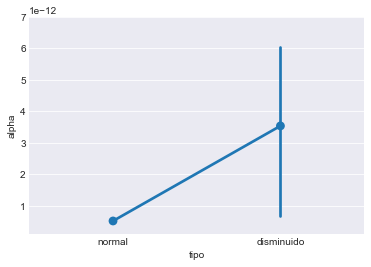

In [22]:
sns.pointplot(x="tipo", y="alpha", data=bandas_frame)
plt.ylim(1e-13, 7e-12)
plt.show()

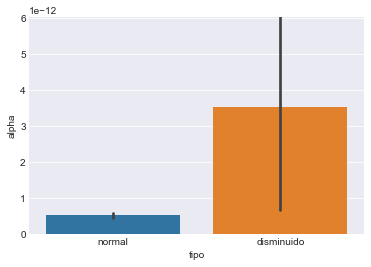

In [23]:
sns.barplot(x="tipo", y="alpha", data=bandas_frame)
plt.show()

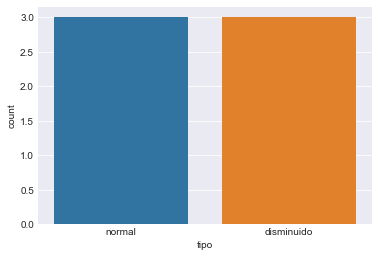

In [24]:
sns.countplot(x="tipo" ,data=bandas_frame)
plt.show()


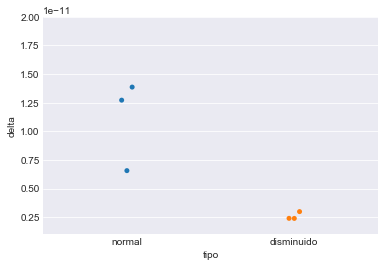

In [25]:
sns.swarmplot(x="tipo", y="delta", data=bandas_frame)
plt.ylim(1e-12, 2e-11)
plt.show()

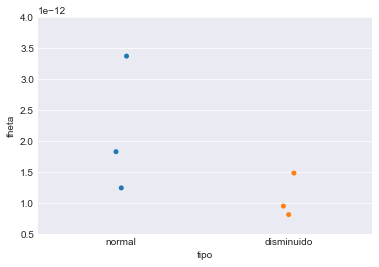

In [26]:
sns.swarmplot(x="tipo", y="theta", data=bandas_frame)
plt.ylim(5e-13, 4e-12)
plt.show()

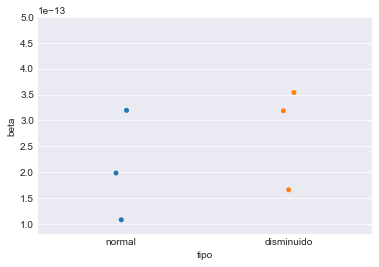

In [27]:
sns.swarmplot(x="tipo", y="beta", data=bandas_frame)
plt.ylim(8e-14, 5e-13)
plt.show()

In [28]:
print bandas_frame


          delta         theta         alpha          beta         gamma  \
0  6.563069e-12  1.246806e-12  4.485051e-13  1.983459e-13  1.604475e-13   
0  2.982860e-12  8.169761e-13  6.708537e-13  3.538571e-13  2.067432e-13   
0  1.272164e-11  3.368208e-12  5.829568e-13  3.194208e-13  1.822494e-13   
0  2.388813e-12  1.485615e-12  6.040987e-12  3.185578e-13  6.348191e-14   
0  1.386406e-11  1.829608e-12  5.376005e-13  1.080624e-13  6.090966e-14   
0  2.395525e-12  9.538994e-13  3.907879e-12  1.659524e-13  2.609784e-14   

         tipo  
0      normal  
0  disminuido  
0      normal  
0  disminuido  
0      normal  
0  disminuido  


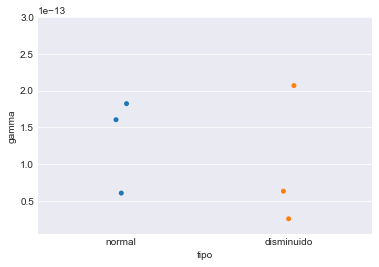

In [29]:
sns.swarmplot(x="tipo", y="gamma", data=bandas_frame)
plt.ylim(5e-15, 3e-13)
plt.show()

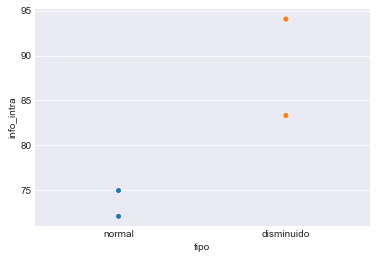

In [20]:
sns.swarmplot(x="tipo", y="info_intra", data=bandas_frame)
plt.show()